In [1]:
import tensorflow.keras as keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

Using TensorFlow backend.


(393732, 7)
88751


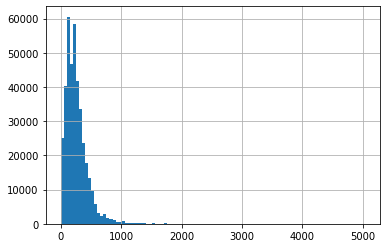

In [2]:
df = pd.read_csv('2018-06-06-ss.cleaned.csv')
df.len.hist(bins=100)
print(df.shape)

def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

In [3]:
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((88751, 128), (88751, 128, 4))

In [11]:
from keras.layers import Embedding, Dense, TimeDistributed, Bidirectional, LSTM
from keras.models import Sequential

In [12]:
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, input_dim=4, activation="softmax")))
model.summary()

8421 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 128, 4)            516       
Total params: 1,177,220
Trainable params: 1,177,220
Non-trainable params: 0
_________________________________________________________________


In [1]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test), verbose=1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Using TensorFlow backend.


In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("sequence : " + str(x))
    print("actual structure: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("predicted structure: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=10
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])